# The `opencadd.structure.pocket` module

Let's walk through the functionalities offered in the `opencadd.structure.pocket` module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd

from opencadd.databases.klifs import setup_remote
from opencadd.structure.pocket import Pocket, KlifsPocket, PocketViewer

RDKit WARNING: [15:55:17] Enabling RDKit 2019.09.3 jupyter extensions
INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


## Get example protein structure and pocket residues

In [3]:
from opencadd.databases.klifs import setup_remote
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


__Fetch protein structure file content__

First of all, we download structural data for an example protein kinase from the KLIFS database (some pocket residues are missing):

https://klifs.net/details.php?structure_id=12347

In [4]:
structure_klifs_id = 12347

In [5]:
text = remote.coordinates.to_text(structure_klifs_id, extension="pdb")

__Fetch pocket residues (or use your own pocket residues)__



In [6]:
pocket_residues = remote.pockets.by_structure_klifs_id(structure_klifs_id)
pocket_residues

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,461,I.1,I,khaki
1,2,462,I.2,I,khaki
2,3,463,I.3,I,khaki
3,4,_,g.l.4,g.l,green
4,5,_,g.l.5,g.l,green
...,...,...,...,...,...
80,81,594,xDFG.81,xDFG,cornflowerblue
81,82,595,xDFG.82,xDFG,cornflowerblue
82,83,_,xDFG.83,xDFG,cornflowerblue
83,84,_,a.l.84,a.l,cornflowerblue


The variables `pocket_residue_ids` and `pocket_residue_ixs` contain the list of residue PDB IDs and residue indices (derived from KLIFS sequence- and structure-based alignment). We will need this pocket information in the next step where we want to set up a pocket from `opencadd`'s `Pocket` class.

In [7]:
pocket_residue_ids = pocket_residues["residue.id"].to_list()
print("Pocket residue PDB IDs:")
print(*pocket_residue_ids)
pocket_residue_ixs = pocket_residues["residue.klifs_id"].to_list()
print("Pocket residue (KLIFS) indices:")
print(*pocket_residue_ixs)

Pocket residue PDB IDs:
461 462 463 _ _ _ _ 468 469 470 471 472 473 480 481 482 483 484 485 497 498 499 500 501 502 503 504 505 506 507 508 509 511 512 513 514 515 516 517 518 519 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 592 593 594 595 _ _ _
Pocket residue (KLIFS) indices:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85


## Pocket (`Pocket` class)

The `Pocket` class currently holds the following attributes/properties:

- `name`: Protein/pocket name
- `filepath`: Path to file with structural protein data
- `centroid`: Centroids of all pocket residues' CA atoms
- `subpockets`: Subpockets defined based on a set of anchor residues each
- `regions`: User-defined regions that are of importance for the protein/pocket
- `anchor_residues`: Anchor residues to define one or more subpockets

### Initialize pocket

We initialize the pocket with the following parameters:
- Protein structure data
- Protein/pocket name
- Pocket residues PDB IDs
- Pocket residue indices (optionally), e.g. for the pocket alignment IDs

In [8]:
pocket = Pocket.from_text(
    text,
    "pdb",
    pocket_residue_ids, 
    pocket_residue_ixs,
    name=structure_klifs_id
)

INFO:opencadd.structure.pocket.base:Pocket 12347 (set pocket residues): The following input residues PDB IDs were assigned to the value None because they cannot be cast to an integer (residue PDB ID, residue index): [('_', 4), ('_', 5), ('_', 6), ('_', 7), ('_', 83), ('_', 84), ('_', 85)]


Let's take a look at key `Pocket` class attributes/properties after initialization.

__Pocket residues__

All residue PDB IDs that cannot be cast to an integer are set to None.

In [9]:
print(*pocket._residue_ids)

461 462 463 None None None None 468 469 470 471 472 473 480 481 482 483 484 485 497 498 499 500 501 502 503 504 505 506 507 508 509 511 512 513 514 515 516 517 518 519 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 592 593 594 595 None None None


In [10]:
print(*pocket._residue_ixs)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85


__Pocket centroids__

In [11]:
pocket.data

,atom.id,atom.name,atom.x,atom.y,atom.z,residue.id,residue.name
73,74,N,9.014,18.239000,51.860001,461,GLN
74,75,CA,8.811,16.811001,51.655998,461,GLN
75,76,C,8.559,16.492001,50.186001,461,GLN
76,77,O,7.851,17.224001,49.491001,461,GLN
77,78,CB,7.630,16.325001,52.500999,461,GLN
...,...,...,...,...,...,...,...
1015,1016,CD1,-0.042,21.966000,31.419001,595,PHE
1016,1017,CD2,1.547,22.907000,29.912001,595,PHE
1017,1018,CE1,-0.337,23.228001,31.899000,595,PHE
1018,1019,CE2,1.255,24.172001,30.389000,595,PHE


In [12]:
pocket.center

INFO:opencadd.structure.pocket.core:Pocket 12347: Missing pocket CA atoms. The pocket center is calculated based on 78 CA atoms (total number of pocket residues is 85).


array([ 0.8315381, 21.615948 , 36.45015  ], dtype=float32)

### Add subpockets

Next, we can add subpockets one-by-one to the pocket. For each subpocket we define the following:
- Subpocket __name__
- __Residue PDB IDs__ OR __residue indices__ (e.g. alignment indices) of all __anchor residues__, i.e. the residues determining the subpocket center (centroid of all anchor residues' CA atoms)
- Subpocket __color__ 

The class method `add_subpocket` uses the `Subpocket` class to set up subpockets.

In [13]:
pocket.add_subpocket("hinge_region", anchor_residue_ixs=[16, 47, 80], color="magenta")
pocket.add_subpocket("dfg_region", anchor_residue_ixs=[19, 24, 81], color="cornflowerblue")
pocket.add_subpocket("front_pocket", anchor_residue_ixs=[10, 48, 72], color="cyan")

Using the `Pocket`'s property `subpockets`, we get an overview of all specified subpockets.

In [14]:
pocket.subpockets

,subpocket.name,subpocket.color,subpocket.center
0,hinge_region,magenta,"[2.4566665, 22.592667, 41.674]"
1,dfg_region,cornflowerblue,"[8.460667, 20.395666, 33.809666]"
2,front_pocket,cyan,"[0.6393334, 16.937, 39.594666]"


Using the `Pocket`'s property `anchor_residues`, we get an overview of all subpockets' anchor residues.

In [15]:
pocket.anchor_residues

,subpocket.name,anchor_residue.color,anchor_residue.id,anchor_residue.id_alternative,anchor_residue.ix,anchor_residue.center
0,hinge_region,magenta,482,None,16,"[8.327, 22.785, 43.461]"
1,hinge_region,magenta,531,None,47,"[-0.001, 24.108, 46.55]"
2,hinge_region,magenta,593,None,80,"[-0.956, 20.885, 35.011]"
3,dfg_region,cornflowerblue,485,None,19,"[15.03, 17.46, 38.074]"
4,dfg_region,cornflowerblue,501,None,24,"[8.524, 25.293, 29.217]"
5,dfg_region,cornflowerblue,594,None,81,"[1.828, 18.434, 34.138]"
6,front_pocket,cyan,470,None,10,"[11.026, 15.031, 41.426]"
7,front_pocket,cyan,532,None,48,"[-3.527, 22.678, 46.33]"
8,front_pocket,cyan,578,None,72,"[-5.581, 13.102, 31.028]"


Subpockets are calculated based on so class anchor residues, defined each in an `AnchorResidue` class. Subpocket centers are the centroids of all anchor residues' centers (i.e. normally the CA atoms).

- If the anchor residue's CA atom is available in the input structure is available, its coordinates are defined as the anchor residues center.
- If the anchor residue's CA atom is missing in a structure, alternative anchors are chosen if possible: If the residue CA atoms before and after the input anchor residue are available, their CA atoms' centroid is chosen. 
- If only one of the neighboring residues' CA atoms is available, that single CA atoms is chosen.
- If none of the anchor residue's and neighboring residues' CA atoms is available, no anchor residue center is defined.

The determination of anchor residues depends on the CA atom availablity of the user-defined anchor residue as well as the residue before and after.

### Add regions

The `Pocket` class also allows to specify pocket regions, normally used to store key regions, such as the hinge region or the catalytic loop in kinases. This information can be used for pocket visualization.

The class method `add_regions` uses the `Regions` class to set up regions.

In [16]:
pocket.add_region("hinge", residue_ixs=[46, 47, 48], color="magenta")
pocket.add_region("linker", residue_ixs=[49, 50, 51, 52], color="cyan")
pocket.add_region("xDFG", residue_ixs=[80, 81, 82, 83], color="cornflowerblue")

INFO:opencadd.structure.pocket.base:Pocket 12347 (set region residues): The following input residues PDB IDs were assigned to the value None because they cannot be cast to an integer (residue PDB ID, residue index): [(None, 83)]


In [17]:
pocket.regions

,region.name,region.color,residue.id,residue.ix
0,hinge,magenta,530,46
1,hinge,magenta,531,47
2,hinge,magenta,532,48
3,linker,cyan,533,49
4,linker,cyan,534,50
5,linker,cyan,535,51
6,linker,cyan,536,52
7,xDFG,cornflowerblue,593,80
8,xDFG,cornflowerblue,594,81
9,xDFG,cornflowerblue,595,82


### Visualize pocket

Besides the pocket, we also want to visualize the co-crystallized ligand (if any), so let's fetch the ligand Expo ID.

In [18]:
ligand_expo_id = remote.structures.by_structure_klifs_id(structure_klifs_id)["ligand.expo_id"][0]

In [19]:
viewer = PocketViewer()
viewer.add_pocket(pocket, ligand_expo_id=ligand_expo_id)

INFO:opencadd.structure.pocket.core:Pocket 12347: Missing pocket CA atoms. The pocket center is calculated based on 78 CA atoms (total number of pocket residues is 85).
INFO:opencadd.structure.pocket.core:Pocket 12347: Missing pocket CA atoms. The pocket center is calculated based on 78 CA atoms (total number of pocket residues is 85).


NGLWidget()

In [20]:
viewer.viewer.render_image(trim=True, factor=2, transparent=True),

(Image(value=b'', width='99%'),)

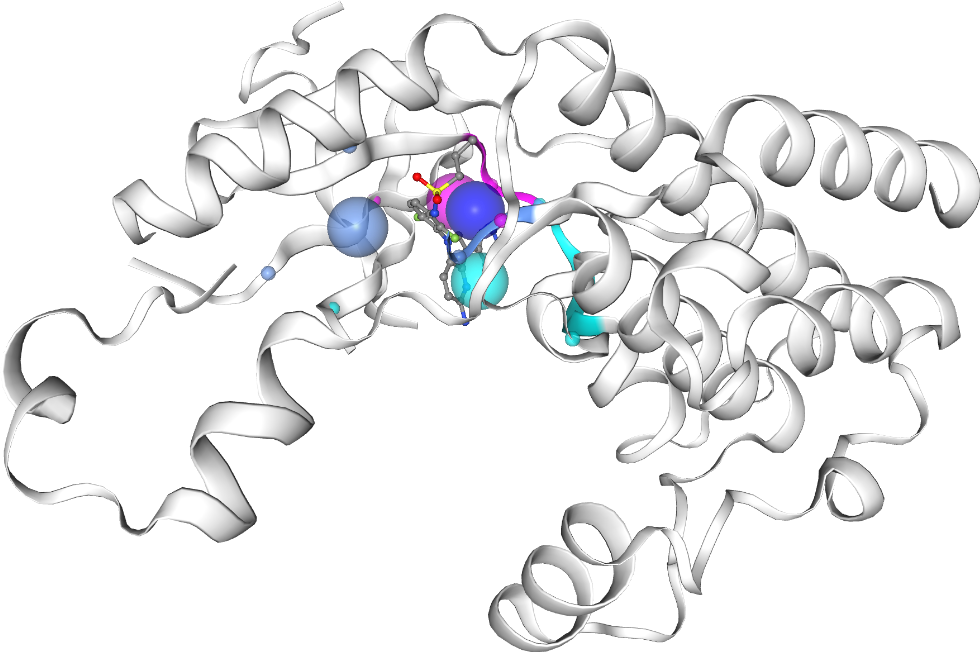

In [21]:
# Static output
viewer.viewer._display_image()

## KLIFS pocket (`KlifsPocket` class)

The `KlifsPocket` class is a child of the `Pocket` class, setting the kinase pocket regions as defined by KLIFS. 

![ba](https://klifs.net/images/faq/colors.png)

_Figure 1_: Kinase pocket regions as defined by KLIFS (taken from the [KLIFS publication](https://pubs.acs.org/doi/abs/10.1021/jm400378w))

Define subpockets (name and color) based on user-defined KLIFS residue IDs.

In [22]:
subpockets = {
    "anchor_residue.klifs_ids": [[16, 47, 80], [19, 24, 81], [10, 48, 72]],
    "subpocket.name": ["hinge_region", "dfg_region", "front_pocket"],
    "subpocket.color": ["magenta", "cornflowerblue", "cyan"]
}
subpockets = pd.DataFrame(subpockets)
subpockets

,anchor_residue.klifs_ids,subpocket.name,subpocket.color
0,"[16, 47, 80]",hinge_region,magenta
1,"[19, 24, 81]",dfg_region,cornflowerblue
2,"[10, 48, 72]",front_pocket,cyan


In [23]:
kinase_pocket = KlifsPocket.from_structure_klifs_id(structure_klifs_id, subpockets)

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!
INFO:opencadd.structure.pocket.base:Pocket 12347 (set pocket residues): The following input residues PDB IDs were assigned to the value None because they cannot be cast to an integer (residue PDB ID, residue index): [('_', 4), ('_', 5), ('_', 6), ('_', 7), ('_', 83), ('_', 84), ('_', 85)]
INFO:opencadd.structure.pocket.base:Pocket 12347 (set region residues): The following input residues PDB IDs were assigned to the value None because they cannot be cast to an integer (residue PDB ID, residue index): [(None, 84), (None, 85)]
INFO:opencadd.structure.pocket.base:Pocket 12347 (set region residues): The following input residues PDB IDs were assigned to the value None because they cannot be cast to an integer (residue PDB ID, residue index): [(None, 4), (None, 5), (None, 6), (None, 7)]
INFO:opencadd.structure.pocket.base:Pocket 12347 (set region residues): The following inpu

### Visualize pocket with all KLIFS-defined regions

In [24]:
viewer = PocketViewer()
viewer.add_pocket(kinase_pocket)

INFO:opencadd.structure.pocket.core:Pocket 12347: Missing pocket CA atoms. The pocket center is calculated based on 78 CA atoms (total number of pocket residues is 85).
INFO:opencadd.structure.pocket.core:Pocket 12347: Missing pocket CA atoms. The pocket center is calculated based on 78 CA atoms (total number of pocket residues is 85).


NGLWidget()

In [25]:
viewer.viewer.render_image(trim=True, factor=2, transparent=True),

(Image(value=b'', width='99%'),)

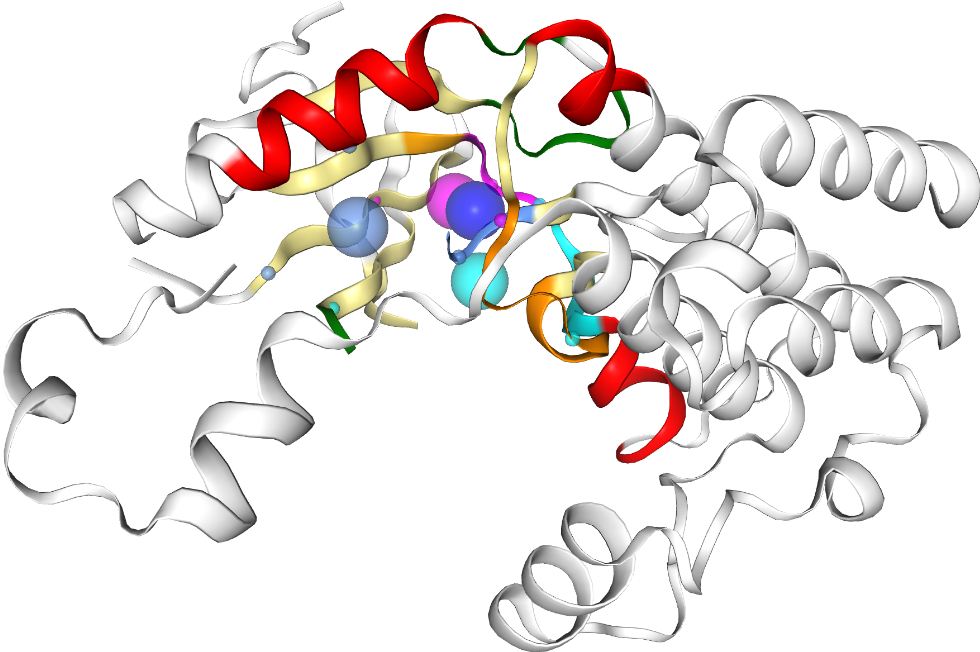

In [26]:
# Static output
viewer.viewer._display_image()